In [ ]:
!pip install clusteval

In [ ]:
!pip install category_encoders

In [8]:
import db_connection as dbcon
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram,linkage
import math
from encoding import target_encoding,binary_encoding
from data_imputation import impute_with_random_forest,impute_with_bayesian_ridge
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import KMeans,DBSCAN
from sklearn.metrics import silhouette_score,davies_bouldin_score
import random
from math import dist
from sklearn.preprocessing import StandardScaler

In [9]:
db=dbcon.DBConnection()
df_source = db.get_dataframe()
df=df_source

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


## Feature Selection for Clustering

In [11]:
cluster_cols=[    "QuantidadeComponente",
    "BitolaCaboAterramentoCarcaca [mm2]",
    "BitolaCabosDeLigacao [mm2]",
    "DiametroExternoEstator [mm]",
    "DiametroUsinadoRotor [mm]",
    "ComprimentoTotalPacote [mm]",]

df[cluster_cols].dtypes

QuantidadeComponente                  Float64
BitolaCaboAterramentoCarcaca [mm2]      Int64
BitolaCabosDeLigacao [mm2]              Int64
DiametroExternoEstator [mm]           Float64
DiametroUsinadoRotor [mm]             Float64
ComprimentoTotalPacote [mm]           Float64
dtype: object

In [28]:
df_rm=df[cluster_cols + ['CustoIndustrial']].dropna()

## Declare functions 

In [49]:
def hierarquical_cluster(df,k=2,title="", plot=True):

    # Create a StandardScaler object
    scaler = StandardScaler()
    
    # Fit the scaler to the features (numeric columns) of the DataFrame
    scaler.fit(df)  # Select numeric columns
    
    # Transform the features (numeric columns) using the fitted scaler
    scaled_df = pd.DataFrame(scaler.transform(df), columns=df.columns)
    
    data = scaled_df.drop('CustoIndustrial', axis=1).values
    distance_matrix = linkage(data, method='ward')

    if plot:
        # Create a dendrogram
        plt.figure(figsize=(10, 6))
        dendrogram(distance_matrix)
        plt.xlabel("Data points")
        plt.ylabel("Distance")
        plt.title("Hierarchical Clustering Dendrogram " + title)
        plt.show()
    
    # Get cluster labels for each data point
    cluster_labels = fcluster(distance_matrix, k, criterion='maxclust')

    silhouette_coeff = silhouette_score(df, cluster_labels)
    davies_bouldin_coeff=davies_bouldin_score(df, cluster_labels)
    print(f"Number of clusters: {k}, Silhouette Coefficient: {silhouette_coeff:.4f}, Davies Bouldin: {davies_bouldin_coeff:.4f} ")
    
    df_with_clusters = df.copy()  # Create a copy to avoid modifying original df
    df_with_clusters['cluster'] = cluster_labels

    return df_with_clusters,silhouette_coeff,davies_bouldin_coeff


def kmeans(df,k=2,title="",plot=True):

    # Create a StandardScaler object
    scaler = StandardScaler()
    
    # Fit the scaler to the features (numeric columns) of the DataFrame
    scaler.fit(df.drop('CustoIndustrial', axis=1))  # Select numeric columns
    
    # Transform the features (numeric columns) using the fitted scaler
    scaled_df = pd.DataFrame(scaler.transform(df.drop('CustoIndustrial', axis=1)), columns=df.drop('CustoIndustrial', axis=1).columns)
    
    data = scaled_df.values
    
    # Create the K-Means object
    kmeans = KMeans(n_clusters=k, random_state=42)
    
    # Fit the model to the data
    kmeans.fit(data)
    
    # Get cluster labels
    cluster_labels = kmeans.labels_
    
    # Get centroids (cluster centers)
    centroids = kmeans.cluster_centers_
     
    if plot:
        plt.scatter(data[:, 0], data[:, 1], c=cluster_labels)
        plt.scatter(centroids[:, 0], centroids[:, 1], marker='o', s=200, c='red', label='Centroids')
        plt.title("K-Means Clustering " + title)
        plt.xlabel("Feature 1")
        plt.ylabel("Feature 2")
        plt.legend()
        plt.show()

    silhouette_coeff = silhouette_score(df, cluster_labels)
    davies_bouldin_coeff=davies_bouldin_score(df, cluster_labels)
    print(f"Number of clusters: {k}, Silhouette Coefficient: {silhouette_coeff:.4f}, Davies Bouldin: {davies_bouldin_coeff:.4f} ")
    
    df_with_clusters = df.copy()  # Create a copy to avoid modifying original df
    df_with_clusters['cluster'] = kmeans.labels_

    #unscaled_centroids = centroids * scaler.scale_ + scaler.mean_

    # Get the mean and standard deviation used for scaling (if not already stored)
    mean_ = scaler.mean_  # Access the mean vector
    std_ = scaler.scale_  # Access the standard deviation vector (might be reshaped for 1D data)
    
    # Unscale the features in the DataFrame
    unscaled_centroids = pd.DataFrame(centroids, columns=df.drop('CustoIndustrial', axis=1).columns) * std_ + mean_

    return df_with_clusters,silhouette_coeff,davies_bouldin_coeff,unscaled_centroids

def describe_cluster(df, all=False):
    cols=df.columns if all else ['CustoIndustrial']
    for col in cols:
        print(f"--- Feature: {col} ---",'\n')
        print(df.groupby('cluster')[col].describe(),'\n\n')
    return None


def dbscan_clustering_study(df, min_samples_values, eps_values):
    results = []
        # Create a StandardScaler object
    scaler = StandardScaler()
    
    # Fit the scaler to the features (numeric columns) of the DataFrame
    scaler.fit(df)  # Select numeric columns
    
    # Transform the features (numeric columns) using the fitted scaler
    scaled_df = pd.DataFrame(scaler.transform(df), columns=df.columns)
    
    data = scaled_df.drop('CustoIndustrial', axis=1).values
    for min_samples in min_samples_values:
        for eps in eps_values:
            db = DBSCAN(eps=eps, min_samples=min_samples).fit(data)
            labels = db.labels_

            # Check for a single cluster or noise-only results
            if len(set(labels)) < 2:
                davies_coef = -1  # Use -1 as an indicator for invalid results
            else:
                davies_coef = davies_bouldin_score(data, labels)

            results.append((min_samples, eps, davies_coef))

    results_array = np.array(results)
    
    # Convert to Pandas DataFrame
    df = pd.DataFrame(results_array, columns=['min_samples', 'eps', 'sil_coef'])
    
    pivot_table = df.pivot(index='min_samples', columns='eps', values='sil_coef')

    plt.figure(figsize=(12, 8))  # Adjust figure size as needed
    heatmap = sns.heatmap(pivot_table, annot=True, cmap="coolwarm")
    heatmap.set_title('DBSCAN Clustering Davies Bouldin Scores')
    heatmap.set_xlabel('eps')
    heatmap.set_ylabel('min_samples')
    plt.show()
    return heatmap

def dbscan(df, min_samples, eps):
        # Create a StandardScaler object
    scaler = StandardScaler()
    
    # Fit the scaler to the features (numeric columns) of the DataFrame
    scaler.fit(df)  # Select numeric columns
    
    # Transform the features (numeric columns) using the fitted scaler
    scaled_df = pd.DataFrame(scaler.transform(df), columns=df.columns)
    
    data = scaled_df.drop('CustoIndustrial', axis=1).values

    db = DBSCAN(eps=eps, min_samples=min_samples).fit(data)
    labels = db.labels_
    
    return db,labels


def hopkins(df, sample_size=150):
  """
  Calculates the Hopkins statistic for a given pandas dataframe.

  Args:
      data: A pandas dataframe representing the data.
      sample_size: The number of points to sample from the data and the uniform distribution (default: 100).

  Returns:
      The Hopkins statistic value.
  """

  # Create a StandardScaler object
  scaler = StandardScaler()
    
  # Fit the scaler to the features (numeric columns) of the DataFrame
  scaler.fit(df)  # Select numeric columns
    
  # Transform the features (numeric columns) using the fitted scaler
  scaled_df = pd.DataFrame(scaler.transform(df), columns=df.columns)
    
  data = scaled_df.drop('CustoIndustrial', axis=1)

  n = len(data)
  d = len(data.columns)  # Number of features (columns)

  # Sample points from the data
  data_sample = data.sample(sample_size)

  # Sample points uniformly from the bounding box
  min_values = data.min(axis=0)
  max_values = data.max(axis=0)
  uniform_sample = []
  for _ in range(sample_size):
    uniform_sample.append(list(random.uniform(min_values[i], max_values[i]) for i in range(d)))

  # Calculate distances within the data sample
  w_sum = 0
  for i in range(sample_size):
    min_dist = float('inf')
    for j in range(sample_size):
      if i != j:
        dist_ij = dist(data_sample.iloc[i], data_sample.iloc[j])
        min_dist = min(min_dist, dist_ij)
    w_sum += min_dist**d

  # Calculate distances within the uniform sample
  u_sum = 0
  for i in range(sample_size):
    min_dist = float('inf')
    for index, point in data.iterrows():
      dist_ip = dist(uniform_sample[i], point)
      min_dist = min(min_dist, dist_ip)
    u_sum += min_dist**d

  # Hopkins statistic
  return w_sum / (u_sum + w_sum)


In [29]:
hopkins_statistic = hopkins(df_rm)
print(f"Hopkins statistic: {hopkins_statistic}") 

# If individuals are aggregated, then its value approaches 0, and if they are randomly distributed, the value tends to 0.5.

/tmp/ipykernel_156/2194094310.py:189: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  uniform_sample.append(list(random.uniform(min_values[i], max_values[i]) for i in range(d)))


Hopkins statistic: 0.0001755428065547242


## Hierarquical Clustering

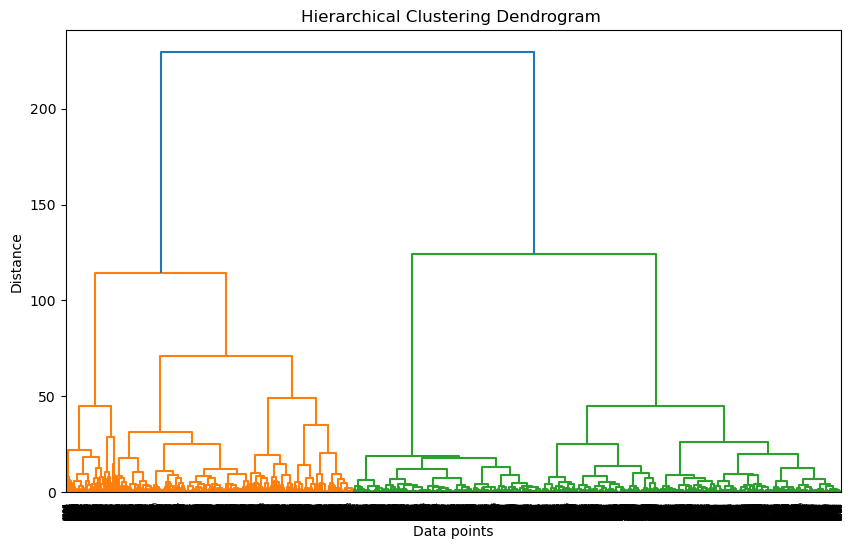

Number of clusters: 2, Silhouette Coefficient: 0.4587, Davies Bouldin: 0.8491 


In [31]:
_,_,_=hierarquical_cluster(df_rm)

In [32]:
fcluster_coeffs=[]
for num_cluster in range(2,11,1):
    _,silhoette,davies=hierarquical_cluster(df_rm, k=num_cluster, plot=False)
    #describe_cluster(df_clustered)
    fcluster_coeffs.append([num_cluster,silhoette,davies])

Number of clusters: 2, Silhouette Coefficient: 0.4587, Davies Bouldin: 0.8491 
Number of clusters: 3, Silhouette Coefficient: 0.4126, Davies Bouldin: 0.7719 
Number of clusters: 4, Silhouette Coefficient: 0.4084, Davies Bouldin: 0.8119 
Number of clusters: 5, Silhouette Coefficient: 0.3654, Davies Bouldin: 1.2785 
Number of clusters: 6, Silhouette Coefficient: 0.3672, Davies Bouldin: 1.2482 
Number of clusters: 7, Silhouette Coefficient: 0.2922, Davies Bouldin: 1.3763 
Number of clusters: 8, Silhouette Coefficient: 0.2919, Davies Bouldin: 1.5501 
Number of clusters: 9, Silhouette Coefficient: 0.2966, Davies Bouldin: 1.3951 
Number of clusters: 10, Silhouette Coefficient: 0.2967, Davies Bouldin: 1.4971 


<Axes: title={'center': 'Scatter Plot of num_clusters vs. davies_coeff'}, xlabel='num_clusters', ylabel='davies_coeff'>

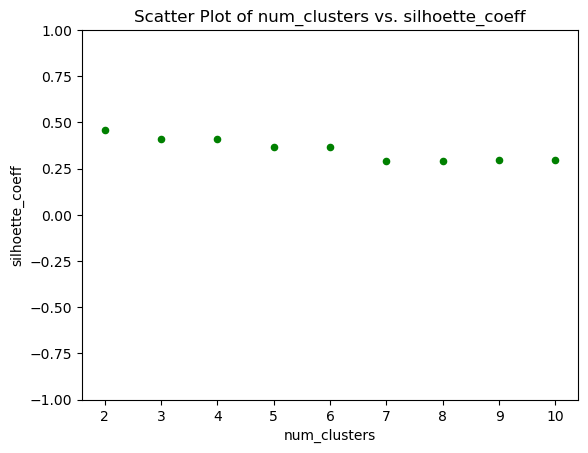

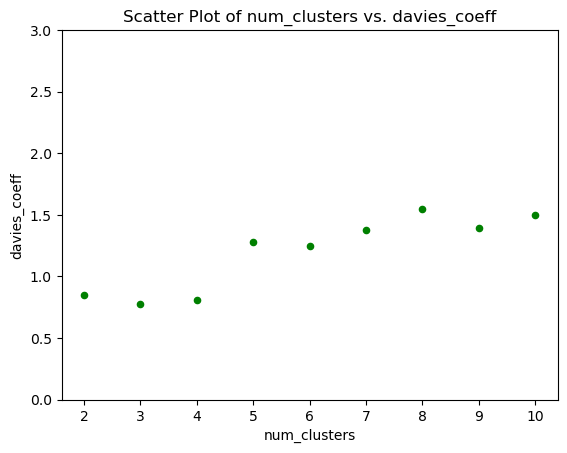

In [35]:
# Choose columns for x and y axes
df_fcluster=pd.DataFrame(fcluster_coeffs)
df_fcluster.columns=['num_clusters','silhoette_coeff','davies_coeff']

x_col = 'num_clusters'

# Create the scatter plot with axis limits from -1 to 1
df_fcluster.plot.scatter(x=x_col, y='silhoette_coeff', marker='o', color='green',
                title='Scatter Plot of ' + x_col + ' vs. ' + 'silhoette_coeff',
                xlabel=x_col, ylabel='silhoette_coeff',ylim=(-1, 1))

# Create the scatter plot with axis limits from -1 to 1
df_fcluster.plot.scatter(x=x_col, y='davies_coeff', marker='o', color='green',
                title='Scatter Plot of ' + x_col + ' vs. ' + 'davies_coeff',
                xlabel=x_col, ylabel='davies_coeff',ylim=(0, 3))

## Kmeans

In [37]:
kmeans_coeffs=[]
for num_cluster in range(2,11,1):
    _,silhoette,davies,__=kmeans(df_rm, k=num_cluster , plot=False)
    #describe_cluster(df_clustered)
    kmeans_coeffs.append([num_cluster,silhoette,davies])

/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Number of clusters: 2, Silhouette Coefficient: 0.5020, Davies Bouldin: 0.7709 


/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Number of clusters: 3, Silhouette Coefficient: 0.4195, Davies Bouldin: 0.7630 


/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Number of clusters: 4, Silhouette Coefficient: 0.4050, Davies Bouldin: 0.9088 


/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Number of clusters: 5, Silhouette Coefficient: 0.3160, Davies Bouldin: 1.0671 


/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Number of clusters: 6, Silhouette Coefficient: 0.3096, Davies Bouldin: 1.3470 


/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Number of clusters: 7, Silhouette Coefficient: 0.2979, Davies Bouldin: 1.4376 


/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Number of clusters: 8, Silhouette Coefficient: 0.3095, Davies Bouldin: 1.2752 


/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Number of clusters: 9, Silhouette Coefficient: 0.2923, Davies Bouldin: 1.4136 


/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Number of clusters: 10, Silhouette Coefficient: 0.3087, Davies Bouldin: 1.5428 


<Axes: title={'center': 'Scatter Plot of num_clusters vs. davies_coeff'}, xlabel='num_clusters', ylabel='davies_coeff'>

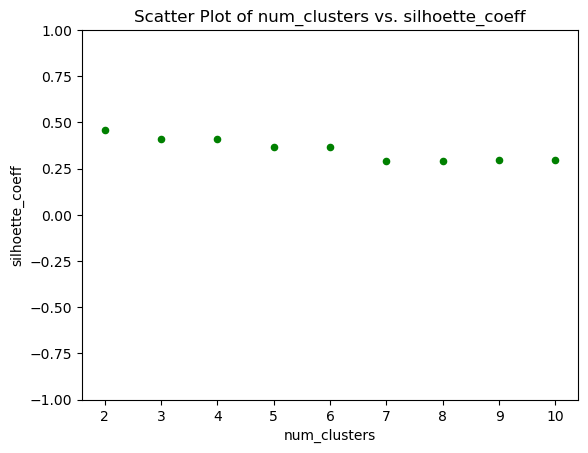

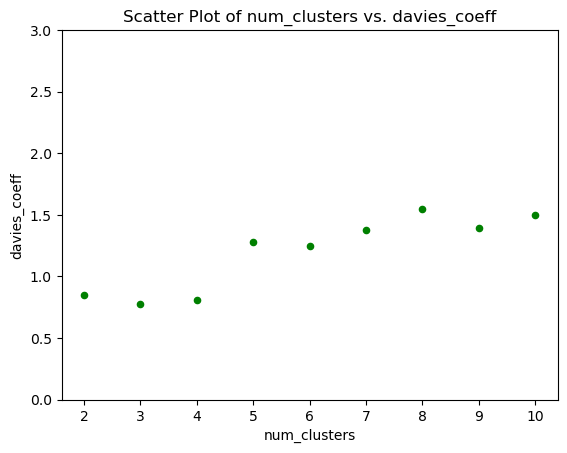

In [38]:
# Choose columns for x and y axes
df_kmeans=pd.DataFrame(kmeans_coeffs)
df_kmeans.columns=['num_clusters','silhoette_coeff','davies_coeff']

x_col = 'num_clusters'

# Create the scatter plot with axis limits from -1 to 1
df_fcluster.plot.scatter(x=x_col, y='silhoette_coeff', marker='o', color='green',
                title='Scatter Plot of ' + x_col + ' vs. ' + 'silhoette_coeff',
                xlabel=x_col, ylabel='silhoette_coeff',ylim=(-1, 1))

# Create the scatter plot with axis limits from -1 to 1
df_fcluster.plot.scatter(x=x_col, y='davies_coeff', marker='o', color='green',
                title='Scatter Plot of ' + x_col + ' vs. ' + 'davies_coeff',
                xlabel=x_col, ylabel='davies_coeff',ylim=(0, 3))



## Overall Results Kmeans vs Fcluster

In [39]:
results_clustering = pd.DataFrame(kmeans_coeffs, columns=['num_clusters','silhoette_coeff_kmeans','davies_coeff_kmeans']).merge(pd.DataFrame(fcluster_coeffs, columns=['num_clusters','silhoette_coeff_aggcluster','davies_coeff_aggcluster']), on='num_clusters', how='inner')
results_clustering

,num_clusters,silhoette_coeff_kmeans,davies_coeff_kmeans,silhoette_coeff_aggcluster,davies_coeff_aggcluster
0,2,0.502015,0.770916,0.458681,0.849055
1,3,0.419513,0.763023,0.412588,0.771868
2,4,0.405022,0.908752,0.408409,0.811938
3,5,0.315975,1.067128,0.365421,1.278470
4,6,0.309623,1.346999,0.367230,1.248234
5,7,0.297947,1.437634,0.292236,1.376268
6,8,0.309489,1.275172,0.291891,1.550116
7,9,0.292340,1.413585,0.296614,1.395122
8,10,0.308717,1.542817,0.296750,1.497053


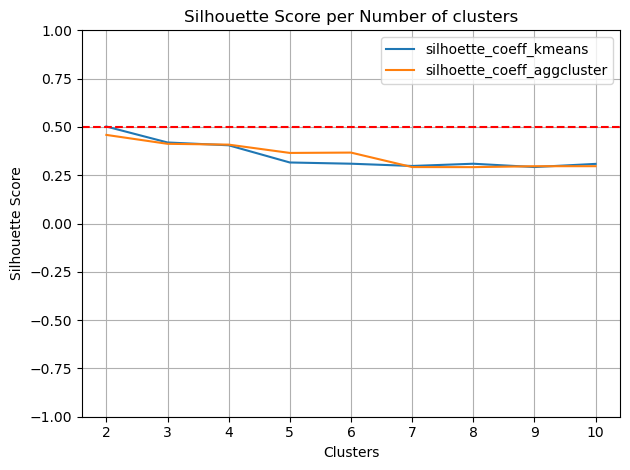

In [40]:
for col in ['silhoette_coeff_kmeans','silhoette_coeff_aggcluster']:
    plt.plot(results_clustering['num_clusters'], results_clustering[col], label=col)

# Add labels and title
plt.xlabel("Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score per Number of clusters")

# Add legend
plt.legend()
plt.ylim(-1, 1)
plt.axhline(y=0.5, color='r', linestyle='--', label='Score = 0.5')  

# Display the plot
plt.grid(True)
plt.tight_layout()

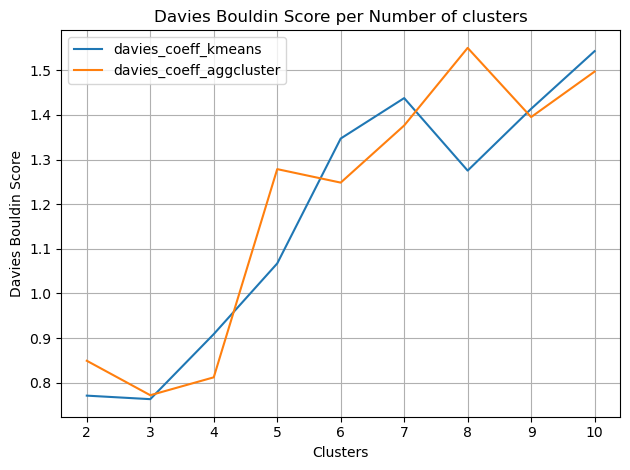

In [41]:
for col in ['davies_coeff_kmeans','davies_coeff_aggcluster']:
    plt.plot(results_clustering['num_clusters'], results_clustering[col], label=col)

# Add labels and title
plt.xlabel("Clusters")
plt.ylabel("Davies Bouldin Score")
plt.title("Davies Bouldin Score per Number of clusters")

# Add legend
plt.legend()

# Display the plot
plt.grid(True)
plt.tight_layout()

# Stator Clusters

In [42]:
df_clustered,silhoette,davies,centroids=kmeans(df_rm, k=2 , plot=False)

/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Number of clusters: 2, Silhouette Coefficient: 0.5020, Davies Bouldin: 0.7709 


In [43]:
centroids.index.name = 'cluster'
centroids.reset_index(inplace=True)
centroids

,cluster,QuantidadeComponente,BitolaCaboAterramentoCarcaca [mm2],BitolaCabosDeLigacao [mm2],DiametroExternoEstator [mm],DiametroUsinadoRotor [mm],ComprimentoTotalPacote [mm]
0,0,34.514380,32.108692,20.800533,460.654524,301.468621,282.455946
1,1,100.621865,89.903558,82.760394,563.643378,364.585898,535.957994


In [44]:
df_clustered[['cluster']].value_counts()

cluster
0          6753
1          2333
Name: count, dtype: int64

In [46]:
centroids.transpose()

,0,1
cluster,0.000000,1.000000
QuantidadeComponente,34.514380,100.621865
BitolaCaboAterramentoCarcaca [mm2],32.108692,89.903558
BitolaCabosDeLigacao [mm2],20.800533,82.760394
DiametroExternoEstator [mm],460.654524,563.643378
DiametroUsinadoRotor [mm],301.468621,364.585898
ComprimentoTotalPacote [mm],282.455946,535.957994


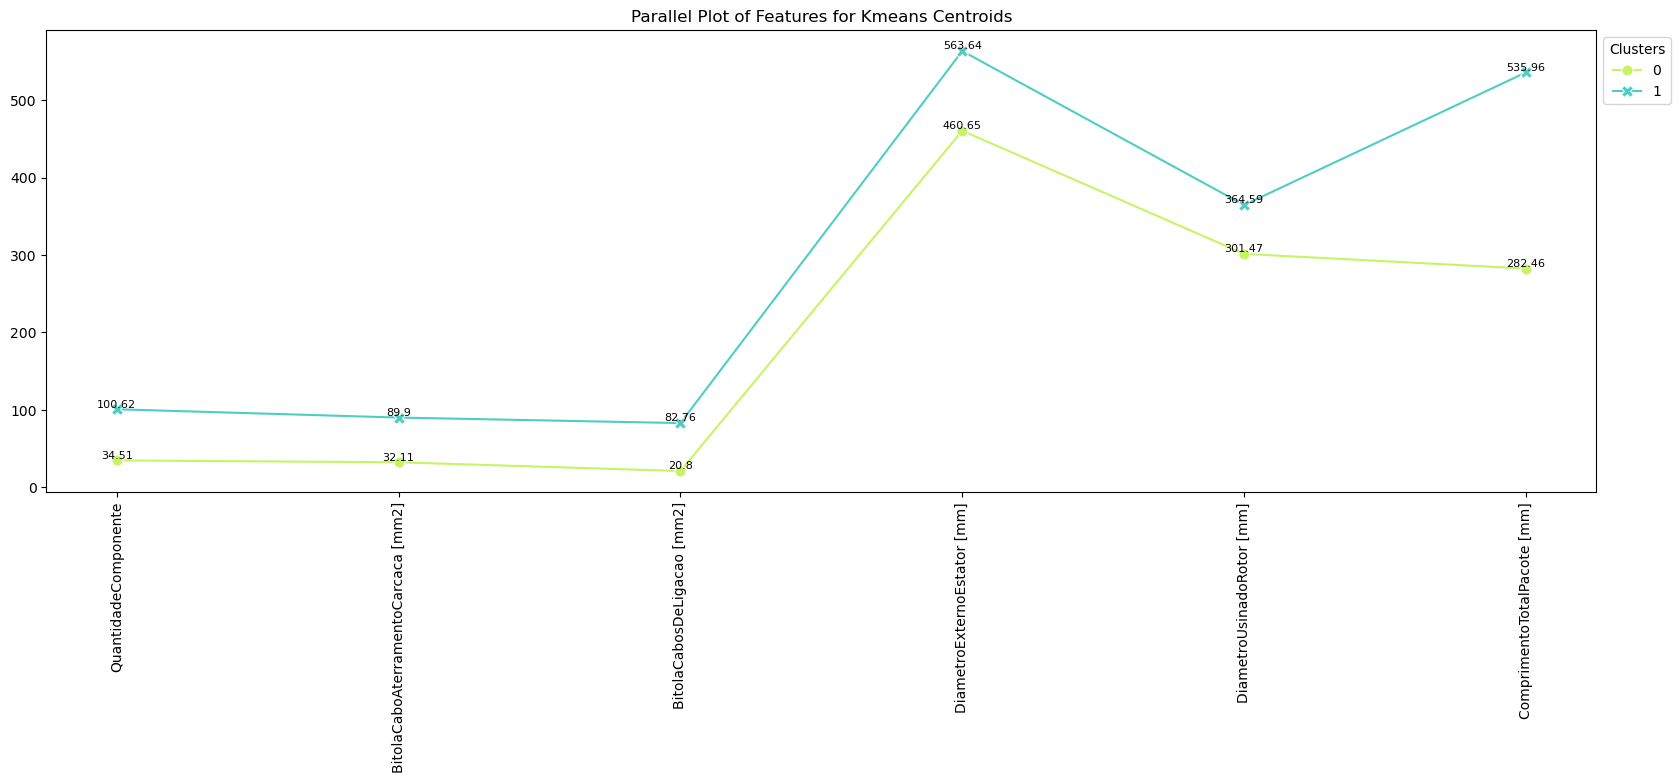

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create parallel plot
plt.figure(figsize=(20, 6))
parallel_plot = sns.lineplot(data=centroids.transpose().drop(index='cluster'),
                             dashes=False,
                             markers=True,
                             markersize=8,
                             palette=['#C7F464', '#4ECDC4'])

# Add title
plt.title('Parallel Plot of Features for Kmeans Centroids')

# Add legend
plt.legend(title='Clusters',
           bbox_to_anchor=(1, 1))  # Shift legend to the right

# Rotate x-axis labels vertically
plt.xticks(rotation=90)

# Add data labels above each marker
for line in parallel_plot.lines:
    x, y = line.get_data()
    for i, (xi, yi) in enumerate(zip(x, y)):
        plt.text(xi, yi, str(round(yi, 2)), color='black', fontsize=8, ha='center', va='bottom')

# Display the chart
plt.show()

## DBSCAN

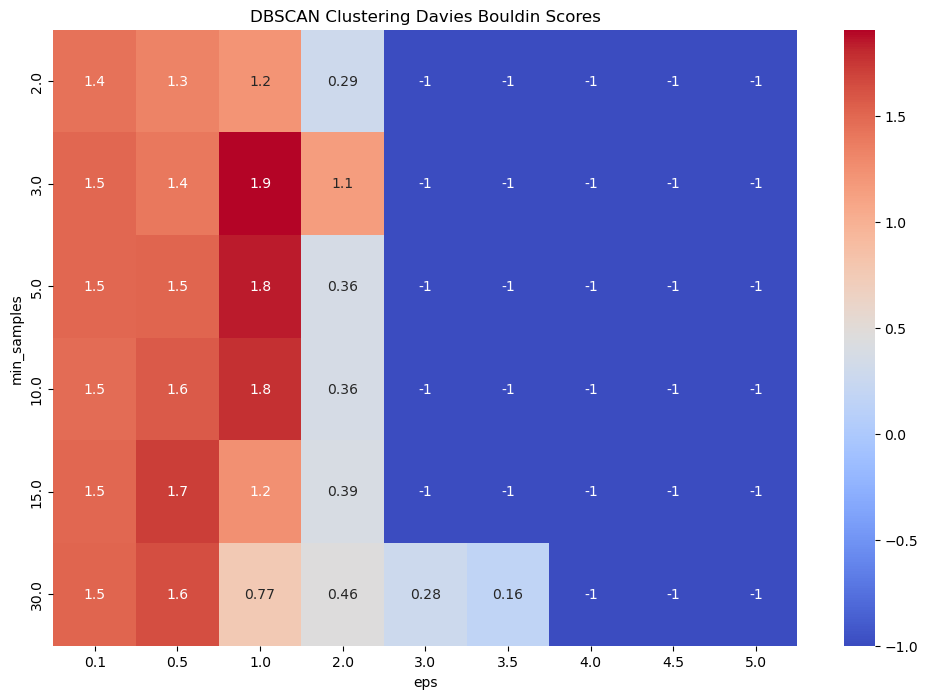

<Axes: title={'center': 'DBSCAN Clustering Davies Bouldin Scores'}, xlabel='eps', ylabel='min_samples'>

In [53]:
min_samples_values=[2,3,5,10,15,30]
eps_values=[0.1,0.5,1,2,3,3.5,4,4.5,5]

dbscan_clustering_study(df_rm, min_samples_values, eps_values)

In [55]:
model,labels=dbscan(df_rm, eps=3.5, min_samples=30)

In [56]:
np.unique(labels)

array([-1,  0])

In [57]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
n_others_ = list(labels).count(0)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Estimated number of others: %d" % n_others_)

Estimated number of clusters: 1
Estimated number of noise points: 1
Estimated number of others: 9085
